In [213]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from unidecode import unidecode
import unicodedata

## ANÁLISES NAVIO TANQUE

In [214]:
#Importando as bases de dados de serviços dos anos de 2022 e 2023
servicos_NT2022 = pd.read_excel("Arquivos\\Relatorio_NT_2022.xlsx")
servicos_NT2023 = pd.read_excel("Arquivos\\Relatorio_NT_2023.xlsx")

In [215]:
#Concatenando as bases dos dois anos em apenas uma única base
servicos_NT=pd.concat([servicos_NT2022, servicos_NT2023])

In [216]:
#Verificando a quantidade de registros da base concatenada
len(servicos_NT)

3285

In [217]:
# Função para retirar os acentos e ç para facilitar as análises futuras
servicos_NT = servicos_NT.map(lambda x: unidecode(str(x)) if isinstance(x, str) else x)

#NOSSO -> Deles

In [218]:
# Alterando para o formato data e hora as colunas para ficarem padronizadas, sendo possível comparar uma com a outra
lFormatDate = ['Data Prevista de Chegada', 'Data Prevista de Saída', 
'H.O.C.', 'Amarração','Início de Bombeio', 'Fim de Bombeio', 'Desamarração', 'H.O.S.', 'Início Primeira Amarração','Fim Primeira Amarração','Início Primeira Conexão','Fim Primeira Conexão',
'Início Primeiro Bombeio','Fim Último Bombeio','Início Última Desconexão','Fim Última Desconexão','Início Última Desamarração','Fim Última Desamarração']

for coluna in lFormatDate:
    servicos_NT[coluna] = pd.to_datetime(servicos_NT[coluna], dayfirst=True)

In [219]:
#Verificando as colunas existentes na base
servicos_NT.columns

Index(['Unidade Operativa', 'Instalação Naval', 'Navio', 'Volume Programado',
       'Data Prevista de Chegada', 'Data Prevista de Saída', 'Viagem',
       'Destino', 'H.O.C.', 'Amarração', 'Início de Bombeio', 'Fim de Bombeio',
       'Desamarração', 'H.O.S.', 'Início Primeira Amarração',
       'Fim Primeira Amarração', 'Início Primeira Conexão',
       'Fim Primeira Conexão', 'Início Primeiro Bombeio', 'Fim Último Bombeio',
       'Início Última Desconexão', 'Fim Última Desconexão',
       'Início Última Desamarração', 'Fim Última Desamarração',
       'Nome da(s) Corrente(s)', 'Volume Retirado', 'Estaçao', 'Bsw (%)',
       'H2SOleo (mg/kg)', 'H2SAgua (mg/l)', 'Salinidade (mg/l)',
       'Temperatura (°C)', 'Densidade 20°', 'Volume de Água Livre (m³)',
       'Responsável', 'Classe do Navio', 'Rebocador', 'Hora Top',
       'Alívio Crítico', 'Apuração Alívio Crítico', 'Volume Acumulado Perdas',
       'Lifter'],
      dtype='object')

In [220]:
servicos_NT.drop(columns=["Classe do Navio","Rebocador","Hora Top","Alívio Crítico","Apuração Alívio Crítico","Volume Acumulado Perdas","Lifter"], inplace=True)

In [221]:
# Temos registros duplicados?
servicos_NT=servicos_NT.drop_duplicates()
len(servicos_NT)
# SIM!! Retiramos 59 casos

3226

In [222]:
#Exportando a base com as alterações já realizadas
servicos_NT.to_excel('Arquivos\\Relatório_NT_Deles.xlsx')

#### Criando novas colunas

In [223]:
#Criando a coluna ID, considerando cada linha como um ID (sendo o ID o indice da linha)
servicos_NT.loc[:,'ID'] = range(0, len(servicos_NT))
columns = ['ID'] + [colunas for colunas in servicos_NT.columns if colunas != 'ID']
servicos_NT = servicos_NT[columns]

In [224]:
#Verificando se a coluna ID foi criada na posição desejada
servicos_NT.columns

Index(['ID', 'Unidade Operativa', 'Instalação Naval', 'Navio',
       'Volume Programado', 'Data Prevista de Chegada',
       'Data Prevista de Saída', 'Viagem', 'Destino', 'H.O.C.', 'Amarração',
       'Início de Bombeio', 'Fim de Bombeio', 'Desamarração', 'H.O.S.',
       'Início Primeira Amarração', 'Fim Primeira Amarração',
       'Início Primeira Conexão', 'Fim Primeira Conexão',
       'Início Primeiro Bombeio', 'Fim Último Bombeio',
       'Início Última Desconexão', 'Fim Última Desconexão',
       'Início Última Desamarração', 'Fim Última Desamarração',
       'Nome da(s) Corrente(s)', 'Volume Retirado', 'Estaçao', 'Bsw (%)',
       'H2SOleo (mg/kg)', 'H2SAgua (mg/l)', 'Salinidade (mg/l)',
       'Temperatura (°C)', 'Densidade 20°', 'Volume de Água Livre (m³)',
       'Responsável'],
      dtype='object')

In [225]:
#Criando a coluna UEP que pega o valor da coluna Instalação Naval e troca tudo que tem PETROBRÁS POR P- para ficar padronizado e similar as bases dos outros tipos de recursos

#Criando uam coluna chamado 'UEP' na posição 2, com todos os registros vazios
servicos_NT.insert(2,'UEP','')

#Percorrendo a base 
for i in servicos_NT:
    #adicionando às linhas da coluna UEP o mesmo valor que essa linha possui na coluna Instalação Naval (ou seja, a plataforma referente ao registro)
    servicos_NT['UEP']= servicos_NT['Instalação Naval']
    #Trocando na coluna UEP tudo que possui a string 'PETROBRAS' por 'P-'
    servicos_NT['UEP']=servicos_NT['UEP'].str.replace('PETROBRAS ', 'P-')

#NOSSO -> Com o deles realmente dá errado

In [226]:
servicos_NT.loc[:,"UEP"] = servicos_NT.loc[:,"UEP"].str.strip()
servicos_NT.loc[:,"Navio"] = servicos_NT.loc[:,"Navio"].str.strip()

In [227]:
# Criando a coluna TNP_H.O.C_Amarracao que seria o tempo não produtivo entre a hora de chegada da embarcação e sua amarração

#Adicionando a coluna "TNP_HOC_Amarracao" com todas os seus registros em branco
servicos_NT["TNP_HOC_Amarracao"]=''

#Percorrendo a base
for i in servicos_NT:
    #Adicionando em cada linha da coluna TNP_HOC_Amarracao a subtração entre o Início Primeira Amarração dessa linha e o H.O.C.
    servicos_NT["TNP_HOC_Amarracao"]= servicos_NT["Início Primeira Amarração"]- servicos_NT["H.O.C."]
#Transformando para hora
servicos_NT['TNP_HOC_Amarracao'] = servicos_NT['TNP_HOC_Amarracao']  / pd.Timedelta(hours=1)

#NOSSO


In [228]:
# Percebemos durante nossas análises que temos H.O.C repetidos e muito distantes da Amarração - isso ocorre devido a erros de preenchimento (repetiram o mesmo HOC pra viagens difernetes de um mesmo navio e plataforma)
# Então iremos considerar H.O.C = Data Prevista de Chegada quando o Tempo_entre_previsto_chegada >= 48horas (2 dias)

#Criando uma lista vazia
HOC = []
#Percorrendo a base
for (idx, val) in servicos_NT.iterrows():
    #Quando o tempo entre a chegada e amarração for maior do que 48h para a linha em questão
    if (val['TNP_HOC_Amarracao']>=48):
        #Adiciona à lista criada o valor da data prevista de chegada da linha em questão
        HOC.append(val['Data Prevista de Chegada'])
    #Caso contrário
    else:
        #Adiciona à lista criada o próprio valor de H.O.C. da linha em questão
        HOC.append(val['H.O.C.'])
#Após percorrer toda a base adicione a lista criada com seus respectivos valores na coluna H.O.C. da base na ordem em que ela está
servicos_NT['H.O.C.'] = HOC

#Logo, teremos na coluna H.O.C. da base H.O.C = Data Prevista de Chegada quando o Tempo_entre_previsto_chegada >= 48horas (2 dias), e caso contrário teremos o valor original do H.O.C para aquele registro

#NOSSO

In [229]:
# REFAZENDO o mesmo código que estava acima, criando as novas colunas (Duração total, tempo entre previsto chegada e tnp entre hoc e amarração), mas agora com a NOVA coluna H.O.C.
servicos_NT["TNP_HOC_Amarracao"]=''
for i in servicos_NT:
    servicos_NT["TNP_HOC_Amarracao"]= servicos_NT["Início Primeira Amarração"]- servicos_NT["H.O.C."]
servicos_NT['TNP_HOC_Amarracao'] = servicos_NT['TNP_HOC_Amarracao']  / pd.Timedelta(hours=1)

#NOSSO

In [230]:
# Criando a coluna TNP_Amarracao_Conexao que seria o tempo não produtivo entre a hora do fim da amarração da embarcação e o início da conexão

#Adicionando a coluna "TNP_Amarracao_Conexao" com todas os seus registros em branco
servicos_NT["TNP_Amarracao_Conexao"]=''

#Percorrendo a base
for i in servicos_NT:
    #Adicionando em cada linha da coluna TNP_Amarracao_Conexao a subtração entre Início Primeira Conexão e o Fim Primeira Amarração dessa linha 
    servicos_NT["TNP_Amarracao_Conexao"]= servicos_NT["Início Primeira Conexão"]- servicos_NT["Fim Primeira Amarração"]
#Transformando para hora
servicos_NT['TNP_Amarracao_Conexao'] = servicos_NT['TNP_Amarracao_Conexao']  / pd.Timedelta(hours=1)

#NOSSO

In [231]:
# Criando a coluna TNP_Conexao_Bombeio que seria o tempo não produtivo entre a hora do fim da conexão da embarcação e o início do bombeio

#Adicionando a coluna "Duracao_Conexao" com todas os seus registros em branco
servicos_NT["TNP_Conexao_Bombeio"]=''

#Percorrendo a base
for i in servicos_NT:
    #Adicionando em cada linha da coluna TNP_Conexao_Bombeio a subtração entre Início Primeiro Bombeio e o Fim Primeira Conexão dessa linha 
    servicos_NT["TNP_Conexao_Bombeio"]= servicos_NT["Início Primeiro Bombeio"]- servicos_NT["Fim Primeira Conexão"]
#Transformando para hora
servicos_NT['TNP_Conexao_Bombeio'] = servicos_NT['TNP_Conexao_Bombeio']  / pd.Timedelta(hours=1)

#NOSSO

In [232]:
# Criando a coluna TNP_Bombeio_Desconexao que seria o tempo não produtivo entre a hora do fim do último bombeio da embarcação e o início da desconexão

#Adicionando a coluna "TNP_Bombeio_Desconexao" com todas os seus registros em branco
servicos_NT["TNP_Bombeio_Desconexao"]=''

#Percorrendo a base
for i in servicos_NT:
    #Adicionando em cada linha da coluna TNP_Bombeio_Desconexao a subtração entre Início Última Desconexão e o Fim Último Bombeio
    servicos_NT["TNP_Bombeio_Desconexao"]= servicos_NT["Início Última Desconexão"]- servicos_NT["Fim Último Bombeio"]
#Transformando para hora
servicos_NT['TNP_Bombeio_Desconexao'] = servicos_NT['TNP_Bombeio_Desconexao']  / pd.Timedelta(hours=1)

#NOSSO

In [233]:
# Criando a coluna TNP_Desconexao_Desamarracao que seria o tempo não produtivo entre a hora do fim da última desconexão da embarcação e o início da última desamarração

#Adicionando a coluna "TNP_Desconexao_Desamarracao" com todas os seus registros em branco
servicos_NT["TNP_Desconexao_Desamarracao"]=''

#Percorrendo a base
for i in servicos_NT:
    #Adicionando em cada linha da coluna TNP_Desconexao_Desamarracaoa subtração entre Início Última Desamarração e o Fim Última Desconexão
    servicos_NT["TNP_Desconexao_Desamarracao"]= servicos_NT["Início Última Desamarração"]- servicos_NT["Fim Última Desconexão"]
#Transformando para hora
servicos_NT['TNP_Desconexao_Desamarracao'] = servicos_NT['TNP_Desconexao_Desamarracao']  / pd.Timedelta(hours=1)

#NOSSO

In [234]:
# Criando a coluna TNP_Desamarracao_HOS que seria o tempo não produtivo entre a hora do fim da última desamarração da embarcação e a hora de saída

#Adicionando a coluna "TNP_Desamarracao_HOS" com todas os seus registros em branco
servicos_NT["TNP_Desamarracao_HOS"]=''

#Percorrendo a base
for i in servicos_NT:
    #Adicionando em cada linha da coluna TNP_Desamarracao_HOS a subtração entre H.O.S.e o Fim Última Desamarração
    servicos_NT["TNP_Desamarracao_HOS"]= servicos_NT["H.O.S."]- servicos_NT["Fim Última Desamarração"]
#Transformando para hora
servicos_NT['TNP_Desamarracao_HOS'] = servicos_NT['TNP_Desamarracao_HOS']  / pd.Timedelta(hours=1)

#NOSSO

In [235]:
servicos_NT = servicos_NT.sort_values(by=['H.O.C.'])
servicos_NT = servicos_NT.drop_duplicates(subset=['Navio', 'Instalação Naval', 'H.O.C.'])
len(servicos_NT)

3221

In [236]:
#Exportando a base com as alterações realizadas
servicos_NT.to_excel('Arquivos\\Relatório_NT_Deles.xlsx')
len(servicos_NT)

3221

#### Análise Inicial das novas variáveis

In [237]:
# ANÁLISE POR TNP
servicos_NT[['TNP_HOC_Amarracao','TNP_Amarracao_Conexao','TNP_Conexao_Bombeio','TNP_Bombeio_Desconexao','TNP_Desconexao_Desamarracao',
             "TNP_Desamarracao_HOS"]].describe().round(2)

,TNP_HOC_Amarracao,TNP_Amarracao_Conexao,TNP_Conexao_Bombeio,TNP_Bombeio_Desconexao,TNP_Desconexao_Desamarracao,TNP_Desamarracao_HOS
count,3221.00,3221.00,3221.00,3221.00,3221.00,3221.00
mean,9.22,0.43,2.46,1.88,0.24,0.80
std,11.13,1.87,3.66,2.06,0.44,3.16
min,-26.83,-0.02,0.02,-5.12,0.02,0.02
25%,3.47,0.07,1.60,1.20,0.03,0.25
50%,4.98,0.20,1.97,1.52,0.17,0.33
75%,10.30,0.33,2.53,2.00,0.30,0.50
max,154.42,45.35,159.07,54.50,17.50,120.25


In [238]:
servicos_NT['TNP_HOC_Amarracao'].sum()

29702.533333333333

In [239]:
# Quantidade de casos negativos dos TNP
TNP_negativos=servicos_NT.loc[servicos_NT['TNP_Amarracao_Conexao']<0]
len(TNP_negativos) # 1 caso
TNP_negativos=servicos_NT.loc[servicos_NT['TNP_Bombeio_Desconexao']<0]
len(TNP_negativos) # 1 caso
TNP_negativos=servicos_NT.loc[servicos_NT['TNP_HOC_Amarracao']<0]
len(TNP_negativos) # 6 casos
TNP_negativos=servicos_NT.loc[servicos_NT['TNP_Conexao_Bombeio']<0]
len(TNP_negativos) # 0 casos
TNP_negativos=servicos_NT.loc[servicos_NT['TNP_Desconexao_Desamarracao']<0]
len(TNP_negativos) # 0 casos
TNP_negativos=servicos_NT.loc[servicos_NT['TNP_Desamarracao_HOS']<0]
len(TNP_negativos) # 0 casos

0

In [240]:
# Excluir os casos em que o Início da Ocorrência seguinte é menor do que o Fim da Ocorrência anterior

servicos_NT=servicos_NT.loc[(servicos_NT['TNP_Amarracao_Conexao']>=0) & (servicos_NT['TNP_Bombeio_Desconexao']>=0) & (servicos_NT['TNP_HOC_Amarracao']>=0) &
                            (servicos_NT['TNP_Conexao_Bombeio']>=0) & (servicos_NT['TNP_Desconexao_Desamarracao']>=0) & (servicos_NT['TNP_Desamarracao_HOS']>=0)]
len(servicos_NT)

#NOSSO -> Com o deles deu errado, não entendi pq

3213

#### Verificações de igualdades

### Alterando o formato da base

In [241]:
# Selecionar apenas as colunas necessárias para alteração no formato do dataframe
nt_colunas = ['ID', 'H.O.C.', 'Início Primeira Amarração', 'Fim Primeira Amarração', 'Início Primeira Conexão', 'Fim Primeira Conexão', 'Início Primeiro Bombeio','Fim Último Bombeio', 'Início Última Desconexão', 'Fim Última Desconexão','Início Última Desamarração', 'Fim Última Desamarração', 'H.O.S.']
# Selecionar e definir as colunas que serão alteradas
colunas_alteradas = ['H.O.C.', 'Início Primeira Amarração', 'Fim Primeira Amarração','Início Primeira Conexão', 'Fim Primeira Conexão', 'Início Primeiro Bombeio','Fim Último Bombeio', 'Início Última Desconexão', 'Fim Última Desconexão','Início Última Desconexão', 'Fim Última Desconexão', 'Início Última Desamarração','Fim Última Desamarração', 'H.O.S.']
# Usar o método melt para transformar as colunas em registros
df_transformado = pd.melt(servicos_NT[nt_colunas], id_vars=['ID'], value_vars=colunas_alteradas, var_name='Ocorrência', value_name='Data')
# Selecionar apenas as colunas necessárias para a junção
colunas_restauradas = ['ID', 'Unidade Operativa', 'UEP', 'Navio', 'Volume Programado','Volume Retirado', 'Viagem', 'Destino', 'Data Prevista de Chegada','Data Prevista de Saída']
# Realizar a junção dos DataFrames usando a coluna 'ID' como chave
NT_novo_formato = pd.merge(servicos_NT[colunas_restauradas], df_transformado, on='ID', how='right')

#NOSSO -> deles

In [242]:
#Ordenando a base da forma correta - por ID e data
NT_novo_formato['Data'] = pd.to_datetime(NT_novo_formato['Data'], format='%d/%m/%Y %H:%M:%S')
NT_novo_formato = NT_novo_formato.sort_values(by=['ID','Data'])

#NOSSO

In [243]:
#Criando colunas de início e fim com todos os registros em branco
NT_novo_formato['Início']=''
NT_novo_formato['Término']=''

#Adicionando os respectivos valores às colunas de início e término - início e fim de cada ocorrência- pois agora temos uma ocorrência em cada linha
#Percorrendo a base
for i, row in NT_novo_formato.iterrows():
    if i < len(NT_novo_formato) - 1:
        #Definindo linha atual e linha seguinte
        linha_atual = NT_novo_formato.iloc[i]
        linha_seguinte = NT_novo_formato.iloc[i+1]
        #Se a linha atual e a linha seguinte forem referentes ao mesmo ID
        if (linha_atual["ID"] == linha_seguinte["ID"]): 
            #A data da linha atual é na verdade o início da ocorrência descrita na linha atual
            NT_novo_formato.at[linha_atual.name, 'Início'] = linha_atual["Data"]
            #E a data da linha seguinte é na verdade o término da ocorrência descrita na linha atual
            NT_novo_formato.at[linha_atual.name, 'Término'] = linha_seguinte["Data"]
        #Caso as linhas não tenham mesmo ID apenas adicionamos o início da ocorrência da linha atual como a data na linha atual
        NT_novo_formato.at[linha_atual.name, 'Início'] = linha_atual["Data"]

#NOSSO -> não tem equivalencia no deles
            

In [244]:
#Excluindo as colunas de fim pois todas as colunas de ínicio ja tem toda a informação
# Filtrar as linhas em que a "Ocorrência" contém a palavra "Fim" e obter seus índices
indices_para_remover = NT_novo_formato[NT_novo_formato['Ocorrência'].str.contains('Fim')].index
# Remover as linhas correspondentes aos índices obtidos
NT_novo_formato.drop(indices_para_remover, inplace=True)


In [245]:
#Renomeando as colunas de Início apenas com o nome da ocorrencia 
NT_novo_formato['Ocorrência'] = NT_novo_formato['Ocorrência'].str.replace('Início ', '')
NT_novo_formato['Ocorrência'] = NT_novo_formato['Ocorrência'].str.replace('Última ', '')
NT_novo_formato['Ocorrência'] = NT_novo_formato['Ocorrência'].str.replace('Primeiro ', '')
NT_novo_formato['Ocorrência'] = NT_novo_formato['Ocorrência'].str.replace('Primeira ', '')


In [246]:
# Removendo colunas que não fazem mais sentido
NT_novo_formato.drop(['Data'],inplace=True, axis=1)

In [247]:
#Exportando a base apenas com as colunas necessárias
NT_novo_formato.to_excel('Arquivos\\Relatório_NT_Deles.xlsx')

In [248]:
#Verificando as colunas existentes
NT_novo_formato.columns

Index(['ID', 'Unidade Operativa', 'UEP', 'Navio', 'Volume Programado',
       'Volume Retirado', 'Viagem', 'Destino', 'Data Prevista de Chegada',
       'Data Prevista de Saída', 'Ocorrência', 'Início', 'Término'],
      dtype='object')

In [249]:
#verificando a quantidade de registros
len(NT_novo_formato)

22491

In [250]:
NT_novo_formato=pd.read_excel('Arquivos\\Relatório_NT_Deles.xlsx')

In [251]:
len(NT_novo_formato)

22491

### Análise das Interrupções

In [252]:
# Importando a base de Interrupções
interrupcoes_NT=pd.read_excel('Arquivos\\eventos_operacoes_interrupcoes2.xlsx')


In [253]:
# Filtrar apenas as linhas em que 'Duração Interrupção' é maior que zero e reatribuir ao DataFrameinterrupcoes_NT
interrupcoes_NT2 =interrupcoes_NT[interrupcoes_NT['Duração Interrupção'] > 0]

In [254]:
interrupcoes_NT2 = interrupcoes_NT2.apply(lambda x: x.map(lambda y: unidecode(str(y)) if isinstance(y, str) else y))

In [255]:
# Alterar os nomes das categorias da coluna UEP pra bater com a base de NT
# Criar a nova coluna "UEP" com valores vazios inicialmente
interrupcoes_NT2.insert(2, 'UEP', '')

# Adicionando os valores da coluna 'Instalação Naval' na coluna 'UEP'
interrupcoes_NT2['UEP'] = interrupcoes_NT2['INNA_SG_INSTALACAO_NAVAL']

# Substituindo 'PETROBRAS ' por 'P-' na coluna 'UEP'
interrupcoes_NT2['UEP'] = interrupcoes_NT2['UEP'].str.replace('PETROBRAS ', 'P-')

In [256]:
# Alterar os nomes das categorias da coluna UEP pra bater com a base de NT
trocaNomes = {
    'FPBAR': 'FPSO Almirante Barroso',
    'FPCGZ': 'FPSO Campos dos Goytacases MV29',
    'CAPX': 'FPSO Capixaba',
    'FPCRC': 'FPSO CARIOCA MV30',
    'FPNIT': 'FPSO Cid. Niteroi MV18',
    'CDAN': 'FPSO Cidade de Anchieta',
    'FPCAR': 'FPSO Cidade de Angra Reis MV22',
    'FPCIB': 'FPSO Cidade de Ilhabela',
    'FPCMB': 'FPSO Cidade de Mangaratiba MV24',
    'FPCIG': 'FPSO Cidade de Itaguai MV26',
    'FPCMC': 'FPSO Cidade de Marica',
    'FPCPY': 'FPSO Cidade de Paraty',
    'FPCST': 'FPSO Cidade de Santos MV20',
    'FPCSQ': 'FPSO Cidade de Saquarema',
    'FPCSP': 'FPSO Cidade Sao Paulo MV23',
    'FPGNB': 'FPSO Guanabara - MV31',
    'FPPLB': 'FPSO Pioneiro de Libra',
    'FSME': 'FSO Cidade de Macae - MV15'
}

# Faz a troca dos nomes da UEP utilizando o replace
interrupcoes_NT2['UEP'] = interrupcoes_NT2['UEP'].replace(trocaNomes)

In [257]:
# Renomear as colunas para ficar com a mesma nomenclatura que a base NT
nomeColunas = {
    'OPOF_CD_VIAGEM': 'Viagem',
    'OPOF_NM_NAVIO': 'Navio',
    'OPOF_NM_DESTINO': 'Destino',
    'EOOF_IN_TIPO': 'TIPO_INTERRUPCAO',
    'Duração Interrupção': 'DURACAO_INTERRUPCAO',
    'EOOF_DT_REALIZADA': 'INICIO_INTERRUPCAO',
    'EOOF_DT_FIM': 'FIM_INTERRUPCAO',
    'OPOF_DT_ENTRADA_PREVISTA': 'Data Prevista de Chegada',
    'OPOF_DT_SAIDA_PREVISTA': 'Data Prevista de Saída'
}

# Renomeando as colunas conforme o dicionário 
interrupcoes_NT2.rename(columns=nomeColunas, inplace=True)

In [258]:
# Retirar o espaço do final dos nomes dos navios
interrupcoes_NT2['UEP'] = interrupcoes_NT2['UEP'].str.strip()
interrupcoes_NT2['Navio'] = interrupcoes_NT2['Navio'].str.strip()

In [259]:
# Selecionando apenas as colunas que interessam
colunasSel = interrupcoes_NT2[['UEP', 'Viagem', 'Navio', 'Destino', 'TIPO_INTERRUPCAO', 'DURACAO_INTERRUPCAO', 'INICIO_INTERRUPCAO', 'FIM_INTERRUPCAO', 'Data Prevista de Chegada', 'Data Prevista de Saída']]

len(interrupcoes_NT2)

414

#### Inclusão da Interrupção na base nova NT

In [260]:
# Importando a base apenas com as colunas necessárias
base_NT=pd.read_excel('Arquivos\\Relatório_NT_Deles.xlsx')

In [261]:
#Verificando a quantidade de linhas da base
len(base_NT)

22491

In [262]:
interrupcoes_NT2.describe()

,EOOF_SQ_EVENTO_OPER_OFFLOAD,OPOF_SQ_OPERACAO,DURACAO_INTERRUPCAO,INICIO_INTERRUPCAO,FIM_INTERRUPCAO,MEOF_SQ_MOTIVO_EVENT_OFFLOAD,EOOF_NM_ARQUIVO_ARMAZENAMENTO,OPOF_SQ_OPERACAO_1,Data Prevista de Chegada,Data Prevista de Saída,...,OPOF_TX_OBSERVACAO,OPOF_SQ_OPERACAO_ANTERIOR,INNA_SQ_INSTALACAO_NAVAL,OPOF_DT_ATUALIZACAO,OPOS_SQ_OPERACAO,OPOF_VL_VAZAO_NV_ALIVIADOR,OPOF_IN_FAIXA_VAZAO_NV_ALIV,OPOF_DT_CADASTRO,OPOF_DT_TOP,OPOF_DS_DIRECAO_VENTO
count,414.000000,414.000000,414.000000,414,414,414.000000,0.0,414.000000,414,414,...,0.0,0.0,414.000000,337,337.000000,0.0,0.0,414,414,90.000000
mean,81346.437198,10667.157005,4.809219,2022-10-06 14:55:30.869565184,2022-10-06 19:44:04.057970688,13.797101,NaN,10667.157005,2022-10-05 15:21:19.855072512,2022-10-07 13:50:13.644927744,...,NaN,NaN,309.362319,2022-10-04 06:13:51.869436160,14413.753709,NaN,NaN,1999-12-04 14:10:24.975845376,1903-07-22 10:55:24.782608640,91.955556
min,59559.000000,8971.000000,0.016667,2022-01-01 00:00:00,2022-01-01 00:24:00,1.000000,NaN,8971.000000,2021-12-31 04:00:00,2022-01-01 19:29:05,...,NaN,NaN,225.000000,2021-12-31 16:42:25,11206.000000,NaN,NaN,1899-12-29 00:00:00,1899-12-29 00:00:00,10.000000
25%,70348.250000,9826.500000,0.500000,2022-05-17 00:27:15,2022-05-17 13:22:30,12.000000,NaN,9826.500000,2022-05-16 00:22:30,2022-05-18 07:17:32.249999872,...,NaN,NaN,240.000000,2022-05-17 15:13:03,12831.000000,NaN,NaN,2022-02-19 06:37:11.500000,1899-12-29 00:00:00,40.000000
50%,81016.000000,10642.000000,1.325000,2022-10-01 09:31:00,2022-10-01 12:26:00,18.000000,NaN,10642.000000,2022-09-30 09:30:00,2022-10-01 22:04:15,...,NaN,NaN,259.000000,2022-09-29 04:50:43,14364.000000,NaN,NaN,2022-07-25 13:58:14,1899-12-29 00:00:00,67.000000
75%,92166.250000,11513.750000,4.575000,2023-02-21 13:03:00,2023-02-21 16:34:30,18.000000,NaN,11513.750000,2023-02-20 12:00:00,2023-02-22 12:03:48,...,NaN,NaN,394.000000,2023-02-17 03:44:21,15928.000000,NaN,NaN,2023-01-06 18:58:17.249999872,1899-12-29 00:00:00,140.000000
max,104136.000000,12431.000000,92.566667,2023-07-27 00:56:00,2023-07-27 01:30:00,18.000000,NaN,12431.000000,2023-07-26 12:00:00,2023-07-27 14:03:41,...,NaN,NaN,482.000000,2023-07-26 19:06:27,17828.000000,NaN,NaN,2023-07-26 19:06:27,2023-07-23 20:52:00,320.000000
std,12865.269127,1000.736541,10.047754,NaN,NaN,5.800759,NaN,1000.736541,NaN,NaN,...,NaN,NaN,80.165864,NaN,1877.303432,NaN,NaN,NaN,NaN,67.684481


In [263]:
base_NT.describe()

,Unnamed: 0,ID,Volume Programado,Volume Retirado,Data Prevista de Chegada,Data Prevista de Saída,Início,Término
count,22491.000000,22491.000000,22491.000000,22491.000000,22491,22491,22490,19278
mean,18130.000000,1610.219421,80744.940554,80277.892009,2022-10-16 02:43:58.209150208,2022-10-17 12:54:49.128540416,2022-10-16 19:52:09.967096320,2022-10-16 22:30:20.989729024
min,0.000000,0.000000,2000.000000,1990.100000,2022-01-01 00:01:00,2022-01-01 23:30:00,2022-01-01 00:01:00,2022-01-01 03:24:00
25%,5622.500000,804.000000,70000.000000,70090.000000,2022-05-23 12:01:00,2022-05-25 09:15:00,2022-05-24 14:37:30,2022-05-24 15:54:15
50%,17671.000000,1608.000000,79400.000000,78946.000000,2022-10-13 14:22:00,2022-10-15 02:54:00,2022-10-14 16:37:00,2022-10-14 19:08:00
75%,29719.500000,2416.000000,86000.000000,85689.250000,2023-03-08 13:00:00,2023-03-09 23:39:34,2023-03-09 10:41:15,2023-03-09 12:00:45
max,38555.000000,3225.000000,166000.000000,170507.000000,2023-07-31 13:00:00,2023-08-01 18:00:00,2023-08-01 16:55:00,2023-08-01 16:48:00
std,12231.423407,931.123604,30100.692333,30300.068265,NaN,NaN,NaN,NaN


#### Base NT para Process Mining

In [264]:
len(base_NT)

22491

In [265]:
#Junção das bases de NT com a de interrupções
base_NT_interrupcoes2 = pd.merge(base_NT, colunasSel,
                                 how = 'left', on = ['UEP','Viagem','Navio','Destino','Data Prevista de Chegada','Data Prevista de Saída'])
len(base_NT_interrupcoes2)

#NOSSO (o colunasSel(deles) já está com essas colunas selecionadas)-> deles

22918

In [266]:
# Restringindo as características de interrupção apenas aos bombeios, visto que só estavamos tratando interrupções nos bombeios
INTERRUPCAO = []
for (idx, val) in base_NT_interrupcoes2.iterrows():
    if ((val['Ocorrência']=='Bombeio') and (val['TIPO_INTERRUPCAO']=='B005')):
        INTERRUPCAO.append("Interrupção Bombeio")
    else:
        INTERRUPCAO.append("")
base_NT_interrupcoes2["TIPO_INTERRUPCAO"] = INTERRUPCAO

DURACAO_INTERRUPCAO = []
for (idx, val) in base_NT_interrupcoes2.iterrows():
    if ((val['Ocorrência']=='Bombeio') and (val['DURACAO_INTERRUPCAO']>0)):
        DURACAO_INTERRUPCAO.append(val["DURACAO_INTERRUPCAO"])
    else:
        DURACAO_INTERRUPCAO.append("")
base_NT_interrupcoes2["DURACAO_INTERRUPCAO"] = DURACAO_INTERRUPCAO

INICIO_INTERRUPCAO = []
for (idx, val) in base_NT_interrupcoes2.iterrows():
    if ((val['Ocorrência']=='Bombeio') and (val['TIPO_INTERRUPCAO']=='Interrupção Bombeio')):
        INICIO_INTERRUPCAO.append(val["INICIO_INTERRUPCAO"])
    else:
        INICIO_INTERRUPCAO.append("")
base_NT_interrupcoes2["INICIO_INTERRUPCAO"] = INICIO_INTERRUPCAO

FIM_INTERRUPCAO = []
for (idx, val) in base_NT_interrupcoes2.iterrows():
    if ((val['Ocorrência']=='Bombeio') and (val['TIPO_INTERRUPCAO']=='Interrupção Bombeio')):
        FIM_INTERRUPCAO.append(val["FIM_INTERRUPCAO"])
    else:
        FIM_INTERRUPCAO.append("")
base_NT_interrupcoes2["FIM_INTERRUPCAO"] = FIM_INTERRUPCAO

#NOSSO-> o deles gera aqueles loops que não devem existir

In [267]:
#verificando as colunas existentes
base_NT_interrupcoes2.columns

Index(['Unnamed: 0', 'ID', 'Unidade Operativa', 'UEP', 'Navio',
       'Volume Programado', 'Volume Retirado', 'Viagem', 'Destino',
       'Data Prevista de Chegada', 'Data Prevista de Saída', 'Ocorrência',
       'Início', 'Término', 'TIPO_INTERRUPCAO', 'DURACAO_INTERRUPCAO',
       'INICIO_INTERRUPCAO', 'FIM_INTERRUPCAO'],
      dtype='object')

In [268]:
# Retirar os duplicados
base_NT_interrupcoes2 = base_NT_interrupcoes2.drop(columns=['Unnamed: 0'])
base_NT_interrupcoes2=base_NT_interrupcoes2.drop_duplicates()
len(base_NT_interrupcoes2)

22550

In [269]:
#Duplicando as linhas em que acontece as interrupções
base_NT_interrupcoes2 = pd.concat([base_NT_interrupcoes2, base_NT_interrupcoes2[base_NT_interrupcoes2['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio'].copy()])

# Resetar índices
base_NT_interrupcoes2.reset_index(drop=True, inplace=True)

#NOSSO, no deles não tinha e ficava uma zona

In [270]:
#Ordenando por ID e Início para deixar os bombeios duplicados juntos e na ordem em que acontecem
base_NT_interrupcoes2.sort_values(by=['ID','Início','INICIO_INTERRUPCAO'],inplace=True)



In [271]:
base_NT_interrupcoes2.describe()

,ID,Volume Programado,Volume Retirado,Data Prevista de Chegada,Data Prevista de Saída,Início,Término
count,22951.000000,22951.000000,22951.000000,22951,22951,22950,19738
mean,1609.505686,80808.546033,80322.672462,2022-10-15 23:16:24.076597760,2022-10-17 09:43:57.524857344,2022-10-16 16:17:19.563398912,2022-10-16 19:02:31.504711424
min,0.000000,2000.000000,1990.100000,2022-01-01 00:01:00,2022-01-01 23:30:00,2022-01-01 00:01:00,2022-01-01 03:24:00
25%,802.500000,70000.000000,70058.000000,2022-05-23 12:00:00,2022-05-25 07:15:35,2022-05-24 10:15:45,2022-05-24 13:03:00
50%,1605.000000,79500.000000,78952.910000,2022-10-13 00:00:00,2022-10-14 20:54:00,2022-10-14 05:06:00,2022-10-14 07:24:00
75%,2416.000000,88000.000000,86020.000000,2023-03-08 13:00:00,2023-03-09 23:39:34,2023-03-09 10:22:30,2023-03-09 11:09:45
max,3225.000000,166000.000000,170507.000000,2023-07-31 13:00:00,2023-08-01 18:00:00,2023-08-01 16:55:00,2023-08-01 16:48:00
std,931.138543,30235.703266,30449.746114,NaN,NaN,NaN,NaN


In [272]:
#Se tem 2 interrupções ou mais no mesmo bombeio só duplica a primeira
indices_para_remover = [] 
for i, row in base_NT_interrupcoes2.iterrows():
    if i < len(base_NT_interrupcoes2) - 2:
        linha_atual = base_NT_interrupcoes2.iloc[i]
        linha_seguinte = base_NT_interrupcoes2.iloc[i+1]
        linha_seguinte_seguinte = base_NT_interrupcoes2.iloc[i+2]
        if ((linha_atual["ID"] == linha_seguinte["ID"]) & (linha_atual['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio') & (linha_seguinte['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio') & (linha_atual['DURACAO_INTERRUPCAO'] != linha_seguinte['DURACAO_INTERRUPCAO'])): 
             indices_para_remover.append(linha_seguinte_seguinte.name)

base_NT_interrupcoes2 = base_NT_interrupcoes2.drop(indices_para_remover)

#NOSSO -> nao tem equivalente no deles


In [273]:
#Percebemos que em alguns casos (Ex: ID 394) o início da interrupção acontece antes do início do bombeio, por isso:
# Verificar se TIPO_INTERRUPCAO está vazio e substituir os valores das outras colunas
condicao = base_NT_interrupcoes2['TIPO_INTERRUPCAO'] == ''
base_NT_interrupcoes2.loc[condicao, ['DURACAO_INTERRUPCAO', 'INICIO_INTERRUPCAO', 'FIM_INTERRUPCAO']] = np.nan

# Substituir o início da interrupção pelo valor de início do bombeio onde necessário
base_NT_interrupcoes2.loc[base_NT_interrupcoes2['INICIO_INTERRUPCAO'] < base_NT_interrupcoes2['Início'], 'INICIO_INTERRUPCAO'] = base_NT_interrupcoes2['Início']

# Substituir o fim da interrupção pelo valor de fim do bombeio onde necessário
base_NT_interrupcoes2.loc[base_NT_interrupcoes2['FIM_INTERRUPCAO'] > base_NT_interrupcoes2['Término'], 'FIM_INTERRUPCAO'] = base_NT_interrupcoes2['Término']        

In [274]:
#Alternado as datas de Término da primeira interrupção e Início da segunda interrupção (considerando também casos com mais de 2 interrupções)
for i, row in base_NT_interrupcoes2.iterrows():
    if i < len(base_NT_interrupcoes2) - 1:
        linha_atual = base_NT_interrupcoes2.iloc[i]
        linha_seguinte = base_NT_interrupcoes2.iloc[i+1]
        if ((linha_atual["ID"] == linha_seguinte["ID"]) & (linha_atual['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio') & (linha_seguinte['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio')): 
            base_NT_interrupcoes2.at[linha_atual.name, 'Término'] = linha_seguinte["INICIO_INTERRUPCAO"]
            base_NT_interrupcoes2.at[linha_seguinte.name, 'Início'] = linha_atual["FIM_INTERRUPCAO"]
        if ((linha_atual["ID"] == linha_seguinte["ID"]) & (linha_atual['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio') & (linha_seguinte['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio')& (linha_atual['DURACAO_INTERRUPCAO'] != linha_seguinte['DURACAO_INTERRUPCAO'])): 
            base_NT_interrupcoes2.at[linha_seguinte.name, 'Início'] = linha_seguinte["FIM_INTERRUPCAO"]

#NOSSO-> deles deu errado, loop do bombeio aumentou e o outro caminho sumiu

In [275]:
#Retirando os casos com bombeio instantâneo
indices_para_excluir = base_NT_interrupcoes2[(base_NT_interrupcoes2["Ocorrência"] == "Bombeio") & (base_NT_interrupcoes2['Início'] == base_NT_interrupcoes2['Término'])].index
base_NT_interrupcoes2 = base_NT_interrupcoes2.drop(indices_para_excluir)
#Agora não aparece mais no process mining bombeios instantâneos.            

#NOSSO -> deles deu errado, o loop do bombeio aumentou e outro caminho sumiu

In [276]:
#Para a ocorrência H.O.S. trocar os términos que estão vazios pelos inícios, pois o H.O.S. é sempre instantâneo.
for index,linha in base_NT_interrupcoes2.iterrows():
    if linha['Ocorrência'] == "H.O.S.":
        if type(base_NT_interrupcoes2.loc[index,'Término']) == pd._libs.tslibs.nattype.NaTType:
            base_NT_interrupcoes2.loc[index,'Término'] = base_NT_interrupcoes2.loc[index,"Início"]
            
#Agora o H.O.S. não está com o término vazio, seu término é igual ao seu início pois é uma atividade instantânea    

In [277]:
#Exportando as bases em formato excel e csv para o process mining
base_NT_interrupcoes2.to_excel('Arquivos\BaseNTFinalDeles.xlsx')
base_NT_interrupcoes2.to_csv('Arquivos\\BaseNTFinalDeles.csv')
#A única coisa estranha que ainda ta acontecendo é que tem um único caso ID 2323 em que não ocorre bombeio, pois a interrupção também começava antes do bombeio, e terminava exatamente no término do bombeio, assim, após fazer aquela modificação de trocar o início da interrupção pelo início do bombeio, o bombeio acabou sendo instantâneo e sendo excluído, logo esse caso está sem bombeio, mas decidimos deixá-lo por enquanto.

In [278]:
#Verificando a quantidade de serviços
len(base_NT_interrupcoes2)

22868

In [279]:
base_NT_interrupcoes2.describe().round(2)

,ID,Volume Programado,Volume Retirado,Data Prevista de Chegada,Data Prevista de Saída,Início,Término
count,22868.00,22868.00,22868.00,22868,22868,22867,22867
mean,1609.47,80827.35,80360.84,2022-10-15 23:12:10.263337472,2022-10-17 09:36:19.107005184,2022-10-16 16:32:07.931954176,2022-10-16 20:41:45.762889984
min,0.00,2000.00,1990.10,2022-01-01 00:01:00,2022-01-01 23:30:00,2022-01-01 00:01:00,2022-01-01 03:24:00
25%,803.00,70000.00,70082.00,2022-05-23 12:00:00,2022-05-25 08:45:00,2022-05-24 11:00:00,2022-05-24 15:05:00
50%,1606.00,79500.00,78952.91,2022-10-13 12:00:00,2022-10-14 23:18:00,2022-10-14 08:48:00,2022-10-14 14:10:00
75%,2416.00,87000.00,86005.44,2023-03-08 13:00:00,2023-03-09 23:39:34,2023-03-09 09:55:00,2023-03-09 12:31:30
max,3225.00,166000.00,170507.00,2023-07-31 13:00:00,2023-08-01 18:00:00,2023-08-01 16:55:00,2023-08-01 16:55:00
std,931.00,30214.85,30407.98,NaN,NaN,NaN,NaN


In [280]:
import pm4py

C:\Users\jcantarino\AppData\Local\Temp\ipykernel_10232\674699035.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log['ID'] = log['ID'].astype(str)
C:\Users\jcantarino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


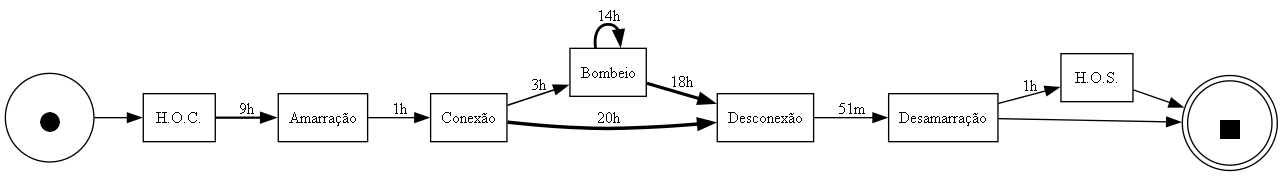

In [281]:
if __name__ == "__main__":
    #Lê o arquivo xlsx que contém o log de eventos
    log = base_NT_interrupcoes2
    if log['Início'].isnull().any():
        log = log.dropna(subset=['Início'])
    log['ID'] = log['ID'].astype(str)
    performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(log, case_id_key='ID', activity_key='Ocorrência', timestamp_key='Início')
    pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities)

C:\Users\jcantarino\AppData\Local\Temp\ipykernel_10232\1018536949.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log['ID'] = log['ID'].astype(str)
C:\Users\jcantarino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


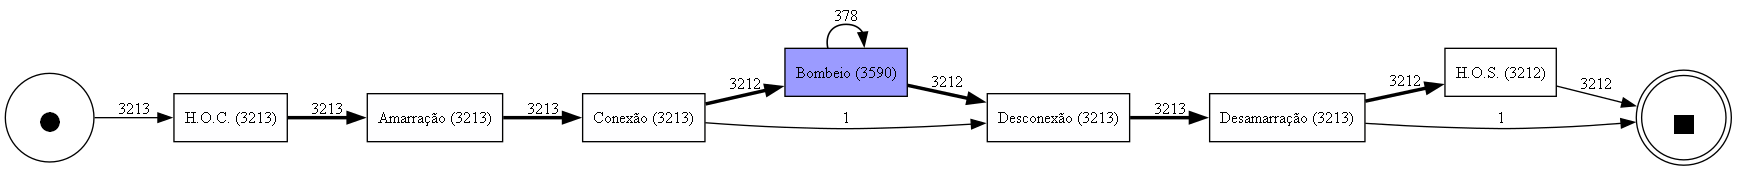

In [282]:
if __name__ == "__main__":
    log = base_NT_interrupcoes2
    if log['Início'].isnull().any():
        log = log.dropna(subset=['Início'])
    #Descobre o grafo de fluxo direcionado (DFG) e as atividades iniciais e finais.
    #O DFG mostra a relação entre as atividades no log de eventos.
    log['ID'] = log['ID'].astype(str)
    dfg, start_activities, end_activities = pm4py.discover_dfg(log,case_id_key='ID', activity_key='Ocorrência', timestamp_key='Início')
    
    #Exibe o grafo de fluxo direcionado (DFG) juntamente com as atividades iniciais e finais.
    #Isso permite visualizar a sequência de atividades no log de eventos.
    pm4py.view_dfg(dfg, start_activities, end_activities)

C:\Users\jcantarino\AppData\Local\Temp\ipykernel_10232\1299073897.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log['ID'] = log['ID'].astype(str)
C:\Users\jcantarino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


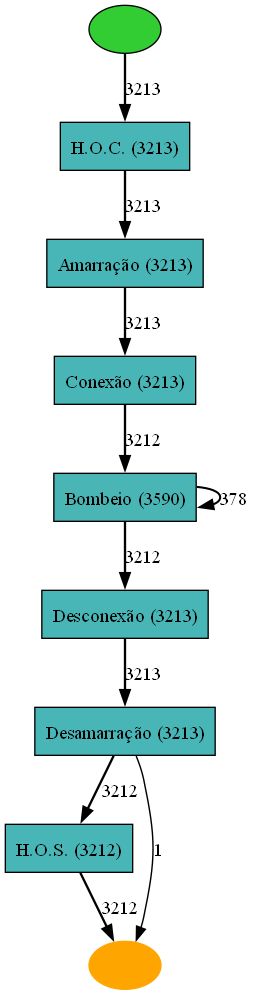

In [283]:
if __name__ == "__main__":
    # Lê o arquivo xlsx que contém o log de eventos
    log = base_NT_interrupcoes2
    if log['Início'].isnull().any():
        log = log.dropna(subset=['Início'])
    # Descobre a rede heurística a partir do log de eventos.
    # A rede heurística é uma representação gráfica de relações entre atividades comuns no log.
    log['ID'] = log['ID'].astype(str)
    heuristics_net = pm4py.discover_heuristics_net(log, case_id_key='ID',activity_key='Ocorrência', timestamp_key='Início')

    # Exibe a rede heurística.
    # Isso permite visualizar as relações entre atividades no log de eventos.
    pm4py.view_heuristics_net(heuristics_net)